<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

# AST4310 2023, Project 2

</div>

In [1]:
%matplotlib inline
# Only if you have a high-resolution "retina" display:
%config InlineBackend.figure_format = 'retina'

import numpy
import matplotlib.pyplot as plt

from astropy import units
from astropy import constants
from astropy.io import fits
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

from scipy.integrate import cumtrapz
from scipy.ndimage import shift  # for "rotating" 3D cubes
from scipy.special import wofz   # for Voigt function
from scipy.special import gamma  # for ABO broadening
from scipy.special import roots_legendre  # for Gaussian quadrature
from scipy.interpolate import CubicSpline

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

i_units = units.Quantity(1, unit="kW m-2 sr-1 nm-1")  # More practical SI units

# Background

In this project you will go beyond simple models of radiation in stars and use more realistic models of a stellar atmosphere, for two different stars. The exercises will build on the different ingredients to achieve the final goal: to calculate the predicted spectral lines from a model atmosphere of a star. This is a fundamental task to study any star in detail.

## 1. Observations

The first part of this project will take you to Procyon, the brightest star in the Canis Minor constelation, the small dog from hunter Orion according to Greek mythology. It is also one of our nearest stars, at only 11.46 light-years from Earth. While it is a binary system, with Procyon B being a faint white dwarf, here we will consider only Procyon A, an F-type main sequence star. Procyon is quite a bit younger than the Sun, but is already much more evolved because it was more massive. It has nearly burned all the hydrogen in its core, and will soon (tens of millions of years) evolve into a subgiant. Its effective temperature is about 6530 K, gravity $\log g$=3.96 (cgs), and its metallicity [Fe/H]$\approx -$0.05 dex, so it is slightly more metal poor than the Sun. (For reference, the solar Fe abundance is 7.5.) It has $M=1.5 M_\odot$ and $L=6.93 L_\odot$. 

In this exercise you will combine high-resolution observations of Procyon's spectrum with your knowledge of spectral line formation to measure the iron content of Procyon. You will follow the footsteps of [Allende Prieto et al. (2002)](https://ui.adsabs.harvard.edu/abs/2002ApJ...567..544A) who studied signatures of convection in Procyon's spectrum and measured the iron abundance from a variety of Fe I and Fe II lines. Unlike Allende Prieto et al. (2002), and for simplicity, you will only use a 1D model and a reduced number of spectral lines.

The observations of Procyon's spectrum were acquired with the [Harlan J. Smith telescope](https://en.wikipedia.org/wiki/Harlan_J._Smith_Telescope) at McDonald Observatory in Texas, USA. With a spectral resolving power of $R\equiv \lambda/\Delta\lambda \approx 2\times 10^5$, this is one of the highest resolution spectra ever taken of a star other than the Sun. The data are available in the file `atlas_procyon_f.fits` and can be read in the following manner:

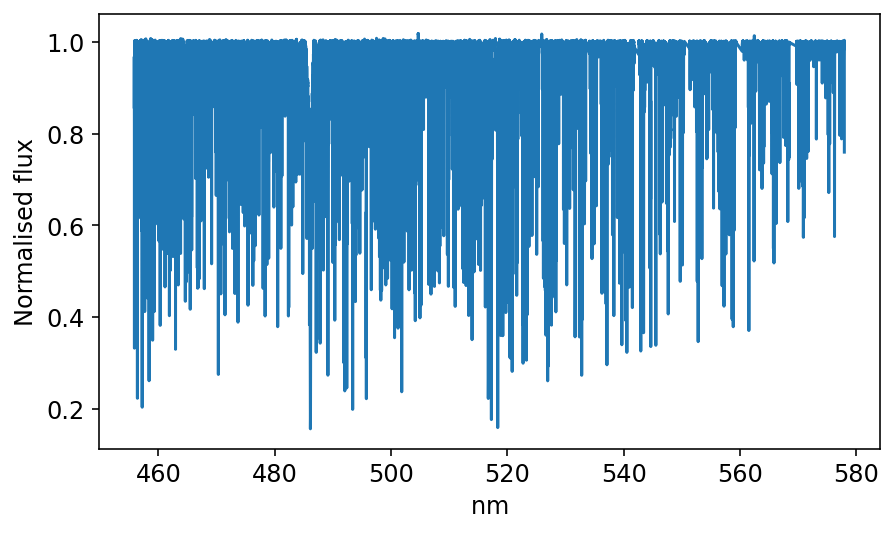

In [2]:
tmp = fits.getdata("atlas_procyon_f.fits")
wave = (tmp[:, 0] * units.AA).to("nm")
flux = tmp[:, 1]

fig, ax = plt.subplots()
ax.plot(wave, flux)
ax.set_ylabel("Normalised flux");

Since we cannot spatially resolve Procyon, we cannot measure the intensity, and observe only the flux. This flux is normalised by the continuum flux, and therefore is dimensionless. 

In the second part of his project you will look at our closest star. The focus will be on the Na I D$_1$ line, one of the strongest in the solar spectrum. The file `int_nad.dat` contains the spectrum of the Na I D$_1$ line (and the surrounding region) taken from the atlas of [Wallace et al. (1998)](https://ui.adsabs.harvard.edu/abs/1998assp.book.....W), observed with the Fourier Transform Spectrometer (FTS) at the [McMath-Pierce solar telescope](https://en.wikipedia.org/wiki/McMath%E2%80%93Pierce_solar_telescope) (previously the largest solar telescope in the world, although mostly retired now) at [Kitt Peak](https://en.wikipedia.org/wiki/Kitt_Peak_National_Observatory). The [FTS](https://www.noao.edu/noao/staff/plymate/fts/aboutFTS.html) remains the highest spectral resolution spectrograph in astrophysics (resolving power $R > $ 10$^6$). The spectra in the file are for disk-centre ($\mu$ = 1) intensity, and are normalised by the continuum intensity. 

The file contains wavenumbers (first column), intensities (third column), and other quantities we don't need. We can load it, convert wavenumbers to wavelengths and assign units by doing the following:

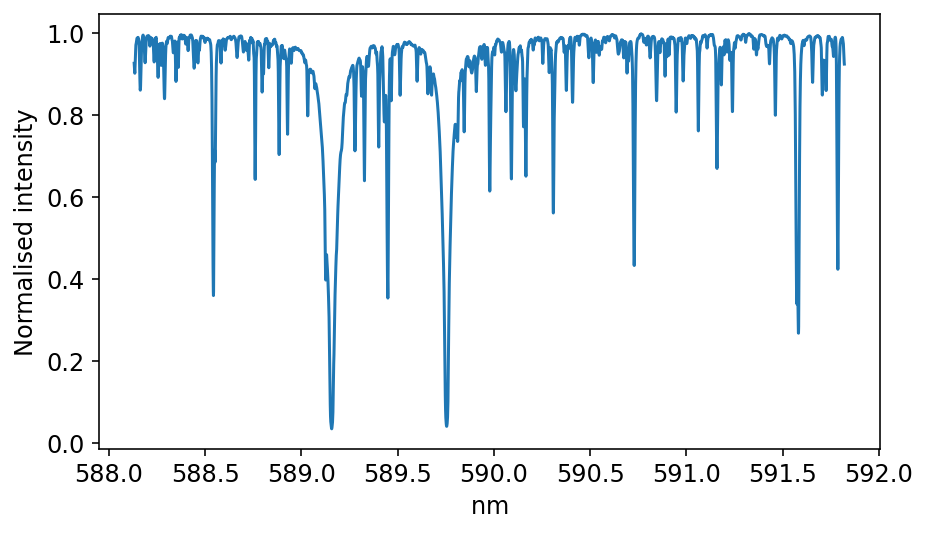

In [3]:
wnum, _, intensity, _ = numpy.loadtxt("int_nad.dat", unpack=True)
wnum = wnum / units.cm
wave = wnum.to("nm", equivalencies=units.spectral())

fig, ax = plt.subplots()
ax.plot(wave, intensity)
ax.set_ylabel("Normalised intensity");

## 2. Model Atmosphere

A model atmosphere is a basic building block to interpret radiation from stars. Different types of models exist, mostly in geometries of 1D plane-parallel, 1D spherical, or 3D (either cartesian or spherical). In this project you will work with a 1D plane-parallel model taken from the [MARCS database](https://marcs.astro.uu.se), and a 3D cartesian model ran with the [Bifrost](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.154G/abstract) code.

A model atmosphere consists of a bunch of thermodynamical variables such as temperature, density, velocity, etc. These are usually tabled in a *depth* scale, meaning that the first point in the z axis is the top of the atmosphere, and the last point is deeper in the star. Normally, together with an appropriate equation of state, quantities such as electron density, hydrogen density, etc. can be provided as well. 

### 2.1 1D MARCS model of Procyon

For Procyon you will work with a model atmosphere in MARCS format, in the file `p6500_g+4.0_m0.0_t01_gs_z+0.05_a+0.11_c+0.08_n+0.09_o+0.12_r+0.00_s+0.00.mod`. This is a text file that can be read with the following function:

In [1]:
def read_MARCS(filename):
    """
    Reads MARCS atmosphere in MOD format. Does not read the whole file, 
    only the most relevant parts.
    """
    data = open(filename, "r").readlines()[1:]
    nlines = len(data)
    # Read basic parameters
    params = {}
    param_names = ["teff", "flux", "surface gravity", "microturbulence", "[Fe/H]"]
    param_units = ["K", "erg/(cm^2 * s)", "cm/s2", "km/s", ""]
    for i in range(4):
        params[param_names[i]] = units.Quantity(float(data[i].split()[0]), unit=param_units[i])
    params[param_names[-1]] = float(data[5].split()[0])
    ndep = int(data[21].split()[0])
    params["ndep"] = ndep
    
    # Model is split into five blocks, read first three
    start_line = 23
    names1 = data[start_line].split()[1:]
    tmp1 = numpy.genfromtxt(filename, skip_header=start_line+2, max_rows=ndep)[:, 1:]
    start_line += ndep + 1
    names2 = data[start_line].split()[2:]
    tmp2 = numpy.genfromtxt(filename, skip_header=start_line+2, max_rows=ndep)[:, 2:]
    start_line += ndep + 2
    names3 = ["HI",] + data[start_line].split()[4:]
    # Get pressures out of log scale
    tmp3 = 10. ** numpy.genfromtxt(filename, skip_header=start_line+2, max_rows=ndep)[:, 2:]
    tmp = numpy.concatenate((tmp1, tmp2, tmp3), axis=-1)
    names = names1 + names2 + names3
    table = numpy.zeros(ndep, dtype={'names': tuple(names), 'formats': ('f8',)*len(names)})
    for i in range(ndep):
        table[i] = tuple(tmp[i])
    table_units = {
        "T": "K", "Pe": "dyn/cm^2", "Pg": "dyn/cm^2", "Prad": "dyn/cm^2", 
        "Pturb": "dyn/cm^2", "Depth": "cm", "KappaRoss": "cm^2/g", 
        "Density": "g/cm^3", "Vconv": "cm/s", "RHOX": "g/cm^2",
        "HI": "dyn/cm^2", "H-": "dyn/cm^2", "H2": "dyn/cm^2", 
        "H2+": "dyn/cm^2", "H2O": "dyn/cm^2", "OH": "dyn/cm^2", 
        "CH": "dyn/cm^2", "CO": "dyn/cm^2", "CN": "dyn/cm^2", "C2": "dyn/cm^2",
    }
    result = QTable(table, meta=params)
    for key, unit in table_units.items():
        result[key].unit = unit
        result[key] = result[key].si  # We don't want to use deprecated units
    return result

This function loads the model into a `astropy.QTable` object, which is a type of tabular array with units. We can read it like:

In [5]:
filename = "p6500_g+4.0_m0.0_t01_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod"
model = read_MARCS(filename)
model

lgTauR,lgTau5,Depth,T,Pe,Pg,Prad,Pturb,KappaRoss,Density,Mu,Vconv,Fconv/F,RHOX,HI,H-,H2,H2+,H2O,OH,CH,CO,CN,C2
,,m,K,N / m2,N / m2,N / m2,N / m2,m2 / kg,kg / m3,,m / s,,kg / m2,N / m2,N / m2,N / m2,N / m2,N / m2,N / m2,N / m2,N / m2,N / m2,N / m2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5.0,-4.9336,-1983000.0,4606.5,0.0018237000000000001,13.930000000000001,0.23867,0.0,0.00011727000000000001,4.6080999999999996e-07,1.267,0.0,0.0,0.141682,12.882495516931337,8.128305161640994e-10,0.00010232929922807536,4.786300923226381e-10,9.332543007969923e-13,8.317637711026709e-08,7.585775750291836e-09,1.584893192461114e-05,2.754228703338169e-09,2.1379620895022325e-10
-4.8,-4.7381,-1896000.0,4643.7,0.0024124000000000003,18.393,0.23871000000000003,0.0,0.00014596,6.035999999999999e-07,1.267,0.0,0.0,0.1881487,16.982436524617444,1.3803842646028838e-09,0.00016218100973589298,8.128305161640994e-10,1.7378008287493763e-12,1.3182567385564074e-07,1.2302687708123813e-08,2.187761623949552e-05,4.0738027780411305e-09,3.311311214825908e-10
-4.6,-4.5493,-1811000.0,4687.7,0.0031992,24.038,0.23875000000000002,0.0,0.00018247,7.814199999999999e-07,1.267,0.0,0.0,0.2470917,21.87761623949552,2.290867652767775e-09,0.0002454708915685031,1.3803842646028838e-09,3.090295432513592e-12,2.0417379446695275e-07,1.9054607179632485e-08,2.8840315031266056e-05,5.754399373371567e-09,4.897788193684457e-10
-4.4,-4.3638,-1727000.0,4732.9,0.0042251,31.193,0.23881000000000002,0.0,0.00022811,1.0042999999999999e-06,1.267,0.0,0.0,0.3217215,28.84031503126606,3.715352290971728e-09,0.0003715352290971724,2.290867652767775e-09,5.2480746024977346e-12,3.090295432513592e-07,2.951209226666384e-08,3.7153522909717244e-05,8.128305161640996e-09,7.079457843841374e-10
-4.2,-4.1791,-1645000.0,4778.9,0.0055612000000000005,40.264,0.23889000000000002,0.0,0.00028513000000000003,1.2839e-06,1.267,0.0,0.0,0.4162504,37.153522909717246,6.165950018614822e-09,0.0005495408738576249,3.890451449942805e-09,8.912509381337441e-12,4.570881896148752e-07,4.570881896148752e-08,4.6773514128719816e-05,1.122018454301963e-08,1e-09
-4.0,-3.9942,-1563000.0,4825.5,0.007299700000000001,51.763000000000005,0.23898000000000003,0.0,0.00035651,1.6346999999999998e-06,1.267,0.0,0.0,0.5360098,47.863009232263856,9.772372209558111e-09,0.0008128305161640995,6.456542290346549e-09,1.5135612484362072e-11,6.760829753919819e-07,6.918309709189364e-08,5.8884365535558894e-05,1.5135612484362072e-08,1.445439770745928e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.9,0.6729,99120.0,9312.9,225.07,4875.1,1.8872,0.0,2.9015000000000004,7.6102e-05,1.209,3723.0,0.78895,49.41784,4073.8027780411308,0.0020417379446695297,0.022387211385683396,0.0030902954325135908,7.585775750291852e-11,1.9054607179632464e-05,3.5481338923357534e-06,3.162277660168379e-07,4.897788193684467e-09,1.4125375446227555e-09


This file has 56 depth points. Each quantity is labeled in the top of the table (same names as defined by MARCS). The most important are temperature (`T`), electron pressure (`Pe`), turbulent velocity (`Vconv`), mass density (`Density`), neutral hydrogen pressure (`HI`), and H$^{-1}$ pressure (`H-`). The pressures from each species can be converted to number density by assuming ideal gases:

$$
P_i = n_i k_B T
$$

We can plot the temperature stratification in Procyon with the following:

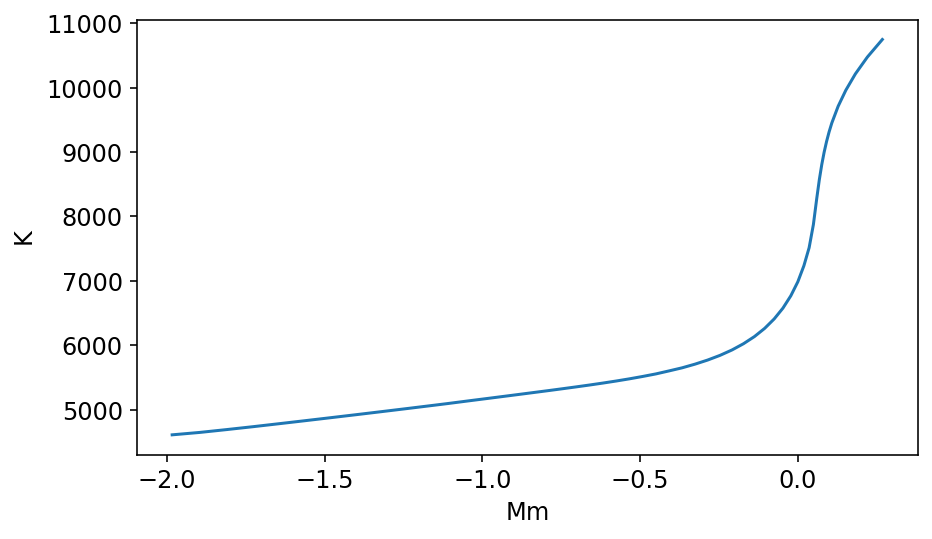

In [6]:
fig, ax = plt.subplots()
ax.plot(model["Depth"].to("Mm"), model["T"]);

### 2.2 3D Bifrost model of the Sun

 <img src="https://i1.rgstatic.net/ii/profile.image/272391284719621-1441954551201_Q512/Robert_Stein.jpg" width="250px" alt="Bob Stein"> <img src="https://www.astro.ku.dk/~aake/aa03-med.jpg" style="width=250px; margin: -75px;" alt="Åke Nordlund">

*[Bob Stein](https://web.pa.msu.edu/people/steinr/research.html) (left, born 1935) and [Åke Nordlund](https://www.astro.ku.dk/~aake/)</a> (right, born 1947) are two pioneers of computer simulations of magneto-hydrodynamics (MHD). Their study of plasma constrained by magnetic fields have had a deep impact in various fields, from planetary formation to the very finest scales in stellar surfaces. In particular, their prolific work on convection in the atmospheres of cool stars has led to a paradigm shift from seeing stellar atmospheres as static 1D plane-parallel objects to highly-dynamic 3D atmospheres. Their seminal work [Simulations of Solar Granulation](https://ui.adsabs.harvard.edu/abs/1998ApJ...499..914S) triggered a new age in the study of the solar and stellar atmospheres, where spectral calculations from 3D MHD simulations of convection became feasible and challenged our understanding of stellar spectra. Using such simulations, the solar metallicity,  stable during decades of modelling and observations, was suddenly challenged and revised by almost half by [Asplund et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005ASPC..336...25A). The codes developed by Nordlund and Stein have thrived and continued to be developed and updated at many research groups. They were at the origin of the Bifrost code, actively developed at the University of Oslo and the source for the simulation in this Project. Photographs from the web.*

The MARCS models are horizontally homogeneous ("plane parallel layers") and in hydrostatic equilibrium ("time independent"). Of course, stellar atmospheres are neither homogeneous nor static. A more realistic description of a stellar atmosphere is given by time-dependent, radiative 3D magneto-hydrodynamic (MHD) simulations. They can capture more physics, such as a realistic treatment of convection and radiation at different depths, and don't need the fudge factors such as microturbulence to make the spectra look like the observations. 

A proper use of 3D models should include the temporal dimension, but for the sake of convenience and speedy calculations, we will use only a single timestep in this exercise. 

The 3D model file is too large to host on Github, so you need to [download it](https://www.uio.no/studier/emner/matnat/astro/AST4310/h20/data/qs006024_sap_s285.fits) (132 MB) and save it to the current directory. This is one timestep of a simulation run with the [Bifrost code](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.154G/abstract). This particular simulation is of quiet Sun (no strong magnetic fields), covers only a relatively small region (6 Mm x 6 Mm horizontal size), and does not include the hotter layers of the transition region and corona (not relevant for this exercise). Here it is saved as a `QTable` in a special type of FITS file, so we can read it by:

In [7]:
# Make sure the path points to the file in your computer
DATA_FILE = "qs006024_sap_s285.fits"
atm3d = QTable.read(DATA_FILE)
atm3d

temperature,electron_density,hydrogen_density,velocity_z,height,velocity_y,velocity_x,pressure
K,1 / m3,1 / m3,m / s,m,m / s,m / s,Pa
"float32[256,256]","float32[256,256]","float32[256,256]","float32[256,256]",float64,"float32[256,256]","float32[256,256]","float32[256,256]"
5272.96923828125 .. 5284.5224609375,4.0828113734598656e+17 .. 4.22937661703979e+17,1.1546960635975193e+21 .. 1.1705831446017663e+21,157.57679748535156 .. 188.99781799316406,583024.0,-591.6886596679688 .. -594.4967041015625,151.15953063964844 .. 138.1940155029297,92.58880615234375 .. 94.07086181640625
5403.09130859375 .. 5411.1669921875,5.892596861260268e+17 .. 6.056246110354145e+17,1.268329059807983e+21 .. 1.2855685577065806e+21,279.1968994140625 .. 312.5419616699219,570330.6,-607.3775634765625 .. -610.0527954101562,148.22718811035156 .. 134.47979736328125,104.22808837890625 .. 105.80181884765625
5457.4619140625 .. 5460.5078125,7.130042222740767e+17 .. 7.238788733091185e+17,1.4060311220144633e+21 .. 1.4257131190234676e+21,397.9075622558594 .. 431.21435546875,557637.2000000001,-673.2451171875 .. -675.8231811523438,133.34869384765625 .. 116.03425598144531,116.7034912109375 .. 118.40267181396484
5481.47607421875 .. 5478.60009765625,8.02345177027969e+17 .. 8.032026586586808e+17,1.5645948428573422e+21 .. 1.5871253666306583e+21,493.31866455078125 .. 525.1014404296875,544943.7999999999,-847.243896484375 .. -849.96142578125,92.8567886352539 .. 66.19844055175781,130.43585205078125 .. 132.2436981201172
5437.236328125 .. 5425.58447265625,7.704930810855424e+17 .. 7.55770551670145e+17,1.7582095166500923e+21 .. 1.7849445728880238e+21,576.6238403320312 .. 605.1107177734375,532250.4,-1198.0218505859375 .. -1198.6129150390625,34.679115295410156 .. -6.235204219818115,145.38577270507812 .. 147.28074645996094
5307.6630859375 .. 5274.84521484375,6.150925743816704e+17 .. 5.789578806490563e+17,2.0056081475177378e+21 .. 2.0432271374176286e+21,639.0731811523438 .. 667.4573364257812,519557.00000000006,-1625.5244140625 .. -1612.75390625,-4.219546318054199 .. -54.43379211425781,161.87940979003906 .. 163.8760986328125
...,...,...,...,...,...,...,...
11589.94921875 .. 11593.806640625,2.6216174006864036e+22 .. 2.6315467119648488e+22,2.038237317915488e+23 .. 2.0436311891171972e+23,2663.761962890625 .. 2643.78955078125,-302254.7,361.02813720703125 .. 359.9884338378906,728.10498046875 .. 742.7396850585938,40124.42578125 .. 40248.75


You notice that while the format is similar, it does not contain the same variables (or names) as the MARCS models. There is no `HI` nor `H-`, only the total number density of hydrogen atoms (includes neutral and ionised) in `hydrogen_density`. `Vconv` is absent, but instead we have `velocity_z`, `velocity_y`, and `velocity_x`, respectively the velocity components in the z, y, and x axes. You will also notice that each variable is now a 3D array, e.g.:

In [8]:
atm3d['temperature'].shape

(75, 256, 256)

The array dimensions are (nz = 75, ny = 256, nx = 256). We can compare some quantities between the MARCS Procyon model and one column of the 3D model:

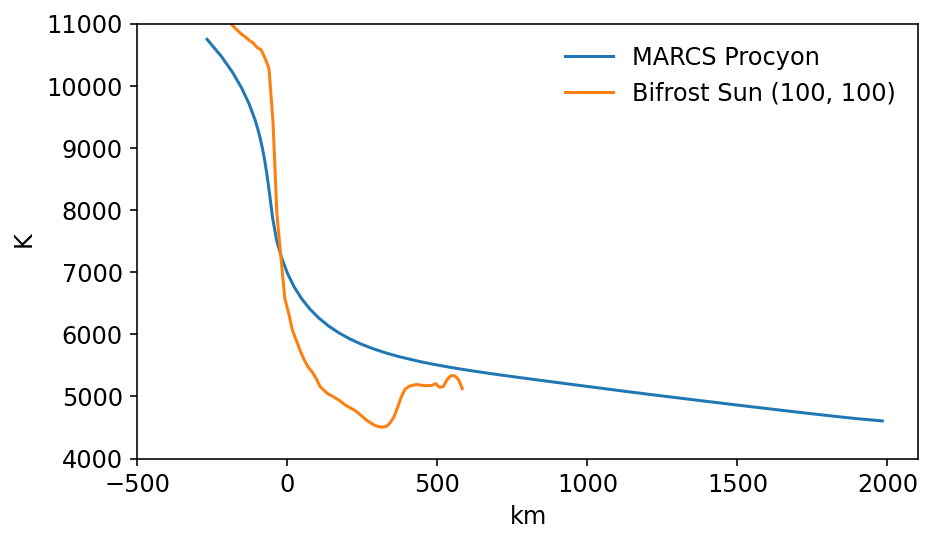

In [9]:
fig, ax = plt.subplots()
ax.plot(-model['Depth'].to('km'), model['T'], label='MARCS Procyon')
# show column (100, 100):
ax.plot(atm3d['height'].to('km'), atm3d['temperature'][:, 100, 100], label='Bifrost Sun (100, 100)')
ax.set_ylim(4000, 11000)
ax.legend();

## 3. Synthetic Spectra


### 3.1 Solving the Radiative Transfer Equation

When we have a model atmosphere and calculate the radiation coming out of it, we call these synthetic spectra (as opposed to observed spectra). To obtain the synthetic spectrum of a model, we need to solve the radiative transfer throughout the atmosphere. In this project, you will calculate only the emergent radiation ($I_\lambda^+$ or $\mathcal{F}_\lambda^+$) by using the formal solution of the radiative transfer equation. Assuming a plane-parallel stratification, it can be written as:

\begin{equation}
    \label{eq:formal}
  I_\lambda = \int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda.
\end{equation}

In this exercise we are assuming LTE, so the source function is simply $S_\lambda=B_\lambda(T)$. The main unknown is therefore the extinction coefficient $\alpha_\lambda$. Once we have the extinction coefficient as function of height, we may compute the corresponding optical depth scale given by:

\begin{equation}
   \tag{1}
  \tau_\lambda(h_0) 
  \equiv -\int_\infty^{h_0} \alpha_\lambda \rm{d} h
              \label{eq:tau_cont}
\end{equation}

at any height $h_0$.  Note that both the model atmospheres (1D and 3D) are tabulated in reverse order, corresponding to the $-h$ direction (ie, depth). For the numerical $\tau$ integration, a simple approach is trapezoidal integration. In this particular case, we want a value of $\tau$ for each height point, so for every point we integrate $\alpha_\lambda$ *up to that point*, and not across the whole range of heights. This is called a *cumulative* integration. Fortunately, `scipy.integrate` has a function `cumtrapz` that does this, so it is possible to calculate $\tau$ with a single call. In general, this type of integration is numerically unstable for radiative transfer, but since here we only want the surface radiation, it is good enough.

The total extinction coefficient $\alpha_\lambda$ is the sum of continuum and line processes:

$$
\alpha_\lambda = \alpha_\lambda^c +\alpha_\lambda^l.
$$

### 3.2 Intensity from different directions of a 1D atmosphere

The disk-centre intensity can be calculated by using the integral expression for $S_\lambda \mathrm{e}^{-\tau_\lambda}$, which you can integrate with `numpy.trapz`. For the general case with different inclinations (given by $\mu=\cos\theta$) in a 1D plane-parallel atmosphere, the emergent intensity is given by

\begin{equation}
\tag{5}
    I_\lambda(0, \mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
    \label{eq:ilambda}
\end{equation}

We transform $\tau_\lambda \to \tau_\lambda/\mu$, meaning that inclined rays go through more material to reach the same depth in the z axis, and this increase in path length also increases the optical depth. This expression can be used to compute the intensity for any inclination (in the 1D case), which we can then use to calculate the surface flux $\cal{F}_\lambda$:

\begin{equation}
\tag{6}
    \mathcal{F}_\lambda = \int I_\lambda \mathrm{d}\Omega  = 2\pi\int_{0}^1\mu I_\lambda(\mu) \mathrm{d}\mu.
\end{equation}

Note that in the lecture notes the flux $\mathcal{F}_\lambda = \pi F_\lambda$, is called "flux", while $F_\lambda$ is called the "astrophysical flux". They differ only by a factor of $\pi$ for a spherical radiator. Numerically, the integral above needs to be discretized in a number of directions given by $\mu_i$, A problem arises that $I_\lambda$ cannot be evaluated at $\mu=0$, so this discretization is often done with a non-equidistant [Gauss-Legendre quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_quadrature). For this project, you can use the following function to compute the weights and integration points (use `k=5`):

In [10]:
def quadrature(k=5):
    """
    Returns the nodes and weights form a Gaussian
    quadrature with k points. Rescaled to an interval
    from [0, 1].
    """
    nodes, weights = roots_legendre(k)
    return nodes/2 + 0.5, weights/2

### 3.3 Intensity from different directions of a 3D atmosphere

In 1D, we just divide $\tau_\lambda$ by $\mu$ to simulate an inclined ray. We can do this because the atmosphere is homogenous in the horizontal direction. However, this is no longer valid in 3D, and to compute the intensity in different directions we need to trace individual rays.

Let's consider first the $\mu$=1 case.  We don't have a plane-parallel semi-infinite atmosphere, but a 3D box with limited horizontal extent. This can also be seen as a set of 1D columns, where each vertical column in the box behaves like a mini-atmosphere. So for $\mu=1$ we can still use the formal solver, solving for each 1D column in the box as it was a plane-parallel atmosphere. A simplistic view of this integration along the height scale will look like this for $\mu=$1:

<img src="https://tiagopereira.space/ast4310/images/ray_straight.svg" height=300px>

Now $S_\lambda$ and $\tau_\lambda$ will be 3D arrays, and for each wavelength the resulting $I_\lambda$ at the top of the atmosphere will be a 2D map (we integrate in the vertical direction).

But how to calculate  $I_\lambda(0, \mu)$ for $\mu\neq 1$? In this case, we cannot simply treat each column in the box as a plane-parallel atmosphere, because inclined rays are going across the box and therefore cross many of those "columns":

<img src="https://tiagopereira.space/ast4310/images/ray_inclined.svg" height=300px>


There are two ways to solve the radiation along inclined rays. One way is to calculate the simulation quantities (temperature, electron density, etc.) along the inclined rays, which needs many interpolations and figuring out which cell the ray intersects at which point. A much easier way is to tilt the simulation box instead of tilting the rays, and use the same functions to integrate along the vertical direction. Such as this diagram:

<img src="https://tiagopereira.space/ast4310/images/box_inclined.svg" height=300px>

One thing we need to sort out is how to deal with the missing "blocks". See the arrow on right side: it must go through some volume, but what values to use there? Here we use a nice property of these simulations: they are horizontally periodic. This means that if we shift one layer of the simulation horizontally, what comes in in the missing right side is what went out of the domain on the left side. 

### 3.4 Continuum Extinction

<img src="https://upload.wikimedia.org/wikipedia/commons/6/67/Subrahmanyan_Chandrasekhar.gif" width=200px>

*Subrahmanyan Chandrasekhar (1910-1995) is regarded by many as the greatest astronomer of the twentieth century. He also played an important role in the topic of this exercise, undertaking a very lengthy and difficult calculation (not a computation, no computers yet at that time!) of the bound-free and free-free extinction cross-sections of the H$^-$ ion, together with F.H. Breen. Their result, published in [Chandrasekhar & Breen (1946)](http://adsabs.harvard.edu/abs/1946ApJ...104..430C) will be duplicated in one of your graphs below. The shape of the extinction curve, 
with a peak near $\lambda$ = 1 μm and a minimum at the H$^-$ bound-free ionisation limit at $\lambda$ = 1.6 μm , reproduced the observed spectral variation of the unknown solar continuum extinction as derived already by G.F.W. Mulders at Utrecht in 1935 for $\lambda$ = 0.4- 2.5 μm. The brilliant suggestion that H$^-$ might cause this extinction, instead of the ensemble of unknown metal edges that was earlier postulated, had already been given by [Pannekoek (1930)](http://adsabs.harvard.edu/abs/1930MNRAS..91..139P), but was forgotten until it came independently from [Wildt (1939)](http://adsabs.harvard.edu/abs/1939ApJ....89..295W). The proof came with Chandrasekhar's laborious quantum mechanical evaluation and explained how the solar atmosphere can be opaque at gas densities much lower than the transparent air around us, as you found in the previous exercise. It revolutionised the understanding of cool-star atmospheres by much increasing their hydrogen-to-metals ratio and gas pressure compared with the earlier metallic-absorption modeling of Biermann, Uns&ouml;ld and Pannekoek himself. A more detailed description is found in [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H). Photograph from Wikimedia commons.*



<img src="https://tiagopereira.space/ast4310/images/gray8-6a.svg" width=700px>

*Continuous extinction coefficients $\kappa_\nu^c$ for hydrogen and helium, per neutral hydrogen atom and per unit electron pressure, for the depth $\tau_0$ = 1 (continuum optical depth at $\lambda$ = 500 nm) in the photosphere of a solar-like dwarf star. The coefficients $\kappa$ are here measured per neutral hydrogen atom in whatever state of excitation, assuming Saha-Boltzmann population partitioning, and normalised by the electron pressure $P_\mathrm{e} = n_\mathrm{e} k \, T$. The cross-sections are in units of 10$^{-26}$cm$^2$ (not cm$^2$ as specified in the $y$-axis label); stimulated emission was not included in the computation of these curves. The H$^-$ curve shows the bound-free Balmer, Paschen and Brackett edges, plus part of the Pfund edge at right. The curves do not extend beyond the Balmer edge at left where the neglected metal edges become important. Thomson scattering is also neglected. From page 140 of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).*


We will assume that H$^-$(a hydrogen atom with an extra electron) is the major provider of continuous extinction.  This is quite a good assumption
for the solar photosphere for wavelengths $\lambda$ > 0.5 μm. The second-best extinction provider are H I bound-free interactions, at only a few percent.  This may be seen in Figure above, taken from [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).

Below $\lambda$ = 500 nm there is heavy line crowding (not added in the figure from Gray) which acts as a quasi-continuum.  Below $\lambda$ = 365 nm the Balmer bound-free edge provides large extinction, and at yet shorter wavelengths the bound-free ionisaton edges of various metals (Al I, Mg I, Fe I, Si I, C I) provide steep extinction increase yet before the H I Lyman continuum sets in, as may be expected from the ionisation edges figure. In this exercise we will neglect these contributions by evaluating only the H$^-$ extinction and the extinction due to scattering off free electrons (Thomson scattering).

To calculate the H$^-$ continuous extinction we will use different tabulated values for the cross section of the H$^-$ bound-free and free-free contribution. For bound-free we use a table based on [Wishart (1979)](https://ui.adsabs.harvard.edu/abs/1979MNRAS.187P..59W) and [Broad and Reinhardt (1976)](https://ui.adsabs.harvard.edu/abs/1976PhRvA..14.2159B) (often referred to as WBR), coded in the function `cross_section_hminus_bf()` below. This function returns the cross section per H$^-$ ion. To obtain the linear extinction $\alpha_\lambda$, you need to multiply it by the number density of H$^-$ atoms (units of m$^{-3}$). In the 1D MARCS model the H$^-$ pressure is given, while for the 3D Bifrost model you need to convert it from neutral hydrogen using the Saha distribution (see below).

For the free-free contribution we will use the recipe from [John (1988)](https://ui.adsabs.harvard.edu/abs/1988A%26A...193..189J/abstract), coded in the function `cross_section_hminus_ff()`. This function returns the "cross section coefficient" (units of m$^5$) per hydrogen atom per electron. To obtain the linear extinction you need to multiply it by the number density of neutral hydrogen atoms and the electron density. The H$^-$ total extinction is the sum of the bound-free and free-free parts. Use the following code to compute it:

In [11]:
def cross_section_hminus_bf(wavelength, temperature):
    """
    Gets the H^- bound-free cross section using the recipes of
    Wishart (1979) and Broad and Reinhardt (1976).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (scalar or array)
        Wavelength to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
        
    Returns
    -------
    cross_section : astropy.units.quantity (scalar or array)
        cross section (in m^2) per H^- ion.
    """
    wbr_λ = numpy.array(
        [  18, 19.6, 21.4, 23.6, 26.4, 29.8, 34.3, 40.4, 49.1, 62.6,  121, 139,
          164,  175,  200,  225,  250,  275,  300,  325,  350,  375,  400, 425,
          450,  475,  500,  525,  550,  575,  600,  625,  650,  675,  700, 725,
          750,  775,  800,  825,  850,  875,  900,  925,  950,  975, 1000, 1025,
         1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325,
         1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1610,
         1620, 1630]
    ) * units.nm  # in nm
    wbr_σ = numpy.array(
        [0.067, 0.088, 0.117, 0.155, 0.206, 0.283, 0.414, 0.703,  1.24,  2.33,
          5.43,  5.91,  7.29, 7.918, 9.453, 11.08, 12.75, 14.46, 16.19, 17.92,
         19.65, 21.35, 23.02, 24.65, 26.24, 27.77, 29.23, 30.62, 31.94, 33.17,
         34.32, 35.37, 36.32, 37.17, 37.91, 38.54, 39.07, 39.48, 39.77, 39.95,
         40.01, 39.95, 39.77, 39.48, 39.06, 38.53, 37.89, 37.13, 36.25, 35.28,
         34.19, 33.01, 31.72, 30.34, 28.87, 27.33, 25.71, 24.02, 22.26, 20.46,
         18.62, 16.74, 14.85, 12.95, 11.07, 9.211, 7.407, 5.677, 4.052, 2.575,
         1.302, 0.8697, 0.4974, 0.1989]
    ) * 1e-22 * units.m**2
    sigma = numpy.interp(wavelength, wbr_λ, wbr_σ)
    # correct for stimulated emission
    sigma = sigma *  (1 - numpy.exp(-constants.h * constants.c /
                                    (wavelength * constants.k_B * temperature)))
    return sigma
    

def cross_section_hminus_ff(wavelength, temperature):
    """
    Gets the H^- free-free cross section coefficient using the recipe
    of John (1988). Includes stimulated emission.
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (scalar)
        Wavelength to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
        
    Returns
    -------
    cross_section : astropy.units.quantity (scalar or array)
        H^- ff cross section coefficient (in m^5) per neutral hydrogen atom per electron.
    """
    table = numpy.array([
        [    0.0000,     0.0000,      0.0000,      0.0000,     0.0000,    0.0000],
        [ 2483.3460,   285.8270,  -2054.2910,   2827.7760, -1341.5370,  208.9520],
        [-3449.8890, -1158.3820,   8746.5230, -11485.6320,  5303.6090, -812.9390],
        [ 2200.0400,  2427.7190, -13651.1050,  16755.5240, -7510.4940, 1132.7380],
        [ -696.2710, -1841.4000,   8624.9700, -10051.5300,  4400.0670, -655.0200],
        [   88.2830,   444.5170,  -1863.8640,   2095.2880,  -901.7880,  132.9850]]
    ) 
    sqrtθ = numpy.sqrt(5040 / temperature.to_value("K"))
    wave_mu = wavelength.to_value("um")
    wave_inv = 1. / wave_mu
    kappa = 0.
    for i in range(6):
        kappa += sqrtθ**(i + 2) * (wave_mu**2 * table[i, 0] + table[i, 1] +
                       wave_inv * (table[i, 2] + wave_inv * (table[i, 3] +
                       wave_inv * (table[i, 4] + wave_inv * table[i, 5]))))
    kappa = kappa * 1e-32 * units.m**4 / units.N  # Put units from table
    return (kappa * constants.k_B * temperature).to("m^5")  

To calculate the number density of neutral hydrogen in the 3D case, we need to use the Saha equation. The H$^-$ number density must be calculated from the neutral hydrogen density using the Saha equation, with the H$^-$ dissociation energy of about 0.12 aJ. In the MARCS model, both the neutral hydrogen pressure and H$^-$ pressures are given is given, so we can just convert them to number densities.  Here are some helpful functions:

In [12]:
def compute_h_neutral_frac(temperature, electron_density):
    """
    Computes the fraction of neutral hydrogen for a given temperature
    and electron density.
    """
    chi_H = 2.1787094174620437 * units.aJ
    saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B) / constants.h**2)**1.5
    saha = (saha_const * temperature**1.5 / electron_density * 
            numpy.exp(-chi_H / (constants.k_B * temperature)))
    return 1 / (1 + saha)

def compute_hminus_frac(temperature, electron_density):
    """
    Computes the fraction of H- divided by neutral hydrogen for a 
    given temperature and electron density.
    """
    chi_Hminus = 0.12080412 * units.aJ
    saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B) / constants.h**2)**1.5
    saha = (4 * saha_const * temperature**1.5 / electron_density * 
            numpy.exp(-chi_Hminus / (constants.k_B * temperature)))
    return 1 / saha

def compute_α_cont(wavelength, temperature, electron_density,
                   h_density, h_minus=None):
    """
    Computes continuum extinction coefficient α using
    Thomson scattering plus the H- bf and ff extinction.
    """
    h_neutral = h_density * compute_h_neutral_frac(temperature, electron_density)
    if h_minus is None:
        # If not provided, compute from neutral hydrogen
        h_minus = h_neutral * compute_hminus_frac(temperature, electron_density)
    alpha_bf = cross_section_hminus_bf(wavelength, temperature) * h_minus
    alpha_ff = cross_section_hminus_ff(wavelength, temperature) * h_neutral * electron_density
    alpha_thomson = 6.648e-29 * units.m ** 2 * electron_density
    return alpha_bf + alpha_ff + alpha_thomson

### 3.5 Line Extinction

We now have almost all the necessary ingredients to calculate synthetic spectra for a model atmosphere. The last remaining ingredient is the line extinction coefficient, $\alpha_\lambda^l$. The monochromatic line extinction per m path length for a bound-bound transition between a lower level $l$  and an upper level $u$ is given by (in SI units, see Rutten IART page 62):
\begin{equation*}
\alpha_\nu^l = \frac{e^2}{4\varepsilon_0 m_ec}n_l f_{lu} \varphi(\nu-\nu_0)\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right].
\end{equation*}

For the line profile we will assume a Voigt profile in wavelength units, $V(a, \lambda)\equiv H(a, u)/(\sqrt{\pi}\Delta\lambda_D)$, with the additional $\lambda^2 / c$ to convert from units per frequency to per wavelength, so the extinction becomes

\begin{equation*}
\alpha_\lambda^l = \frac{e^2}{4\varepsilon_0 m_ec}n_l f_{lu}\frac{\lambda^2}{c}\frac{H(a, u)}{\sqrt{\pi}\Delta\lambda_D}\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right].
\end{equation*}


The two main unknowns above are the lower level populations $n_l$ and the line profile $H(a, u)$, which we address below.


#### 3.5.1 Level populations

The lower level populations $n_l$ are total number density of atoms in level $l$. An atomic level is related to $r$, a given ionisation stage (e.g. for a Na I line, $r=0$, for Na II, $r=1$, and so on). To obtain $n_l$, we first need to know $N_E$, the number density of atoms from element E, then how many of those are in ionisation stage $r$, and finally of those how many are in level $l$. $n_E$ is usually known by its ratio to the hydrogen number density, $N_H$. We can decompose $n_l$ in quantities that are more readily available:

\begin{equation*}
n_l = \frac{n_l}{N_E}\frac{N_E}{N_H}N_H.
\end{equation*}

$N_H$ is usually known from the model atmosphere, and $N_E/N_H$ is the abundance of the element relative to hydrogen. To make matters slightly confusing, astronomers usually define the abundance of an element not as $N_E/N_H$ but as a log quantity called $\epsilon_E$ or $A_E$:

\begin{equation*}
A_E \equiv \log_{10}\left(\frac{N_E}{N_H}\right) + 12.
\end{equation*}

Replacing in $n_l$ above, we get:
\begin{equation*}
n_l = \frac{n_l}{N_E} 10^{(A_E -12)}  N_H.
\end{equation*}

Since we are in LTE, the quantity $n_l/N_E$ is given by the combined Saha and Boltzmann distributions

\begin{eqnarray*}
   U_r 
   &\equiv& \sum_s g_{r,s} e^{-\chi_{r,s}/k_B T}
             \label{eq:parfunc} \\
   \frac{n_{l}}{N_r}
   &=& \frac{g_{l}}{U_r} e^{-\chi_{l}/k_B T}
             \label{eq:Boltzmann} \\
   \frac{N_{r+1}}{N_r}
   &=& \frac{1}{N_\mathrm{e}} \frac{2U_{r+1}}{U_r}
       \left(\frac{2 \pi m_\mathrm{e} k_B T}{h^2}\right)^{3/2} 
       e^{-\chi_r/k_B T},
            \label{eq:Saha}
\end{eqnarray*}

so that
\begin{equation*}
\frac{n_l}{N_E} = \frac{n_l}{N_r} \frac{N_r}{N_E},
\end{equation*}

where $n_l/N_r$ is given by the Boltzmann equation and $N_r/N_E$ (where $N_E = \sum_r N_r$) can be obtained by multiple runs of the Saha distribution, to obtain the ratios for all necessary states. This was what you did in Project 1. However, in that `Atom()` class you calculated the populations for all levels in all stages, which is overkill, especially when you have large atoms (e.g. Fe). It is more handy to compute $n_l/N_r$ only for the level of interest (the lower level of the spectral line), and only run the Saha sum for the most important ionisation stages.

Using the expression above for $n_l/N_r$ we get an expression that depends on the partition function $U_r(T)$, the lower level energy (or potential) $\chi_l$, and the statistical weight of the lower level $g_l$. The latter one is often combined in the ratio with $f_{lu}$ in the expression for $\alpha_\lambda$, so that we get:

\begin{equation}
\alpha_\lambda^l = \frac{e^2}{4\varepsilon_0 m_ec} g_l f_{lu} \frac{e^{-\chi_{l}/k_B T}}{U_r}  \frac{N_r}{N_E} 10^{(A_E -12)} N_H \frac{\lambda^2}{c}\frac{H(a, u)}{\sqrt{\pi}\Delta\lambda_D}\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right].
\end{equation}

The term $g_l f_{lu}$ ("gf-value") is often given in log form, $\log_{10}(gf)$, and is a measure of the transition strength. To calculate the partition functions for Fe or Na atoms, use the functions below. You can supply either a scalar temperature, or for more efficiency, an array:

In [13]:
def pfunction_Fe(temperature, stage=0):
    """
    Computes partition function for Fe I, Fe II, Fe III,
    depending on stage (Fe I: stage=0, Fe II: stage=1).
    
    Based on data from Gray (2005), p. 515.
    """
    θ = numpy.arange(0.2, 2.01, 0.2) 
    logU = numpy.array([
        [3.760, 2.049, 1.664, 1.519, 1.446, 1.402, 1.372, 1.350, 1.332, 1.317],
        [2.307, 1.881, 1.749, 1.682, 1.638, 1.604, 1.575, 1.549, 1.525, 1.504],
        [1.887, 1.518, 1.411, 1.370, 1.350, 1.337, 1.328, 1.320, 1.312, 1.304],
    ])
    θ_in = 5040. * units.K / temperature
    return 10. ** CubicSpline(θ, logU[stage])(θ_in)


def pfunction_Na(temperature, stage=0):
    """
    Computes partition function for Na I, Na II, Na III,
    depending on stage.
    """
    θ = numpy.arange(0.2, 2.01, 0.2) 
    logU = numpy.array([
        [2.014, 1.127, 0.542, 0.354, 0.315, 0.305, 0.303, 0.302, 0.301, 0.301],
        [2.46e-6, 3.6e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.767, 0.757, 0.747, 0.737, 0.729, 0.72, 0.713, 0.705, 0.698, 0.692],
    ])
    θ_in = 5040. * units.K / temperature
    return 10. ** CubicSpline(θ, logU[stage])(θ_in)

To calculate $\alpha_\lambda^l$ (without the line profile), you will need a function similar to the one below:

In [14]:
def compute_α_line(temperature, electron_density, h_density, doppler_width,
                            pfunction, wave0, loggf, χ, stage, abund): 
    """
    Compute line extinction without the profile.
    
    Parameters
    ----------
    temperature: astropy.units.quantity (scalar or array)
        Atmospheric temperature(s).
    electron_density: astropy.units.quantity (scalar or array)
        Electron density from atmosphere.
    h_density: astropy.units.quantity (scalar or array)
        Number density of hydrogen atoms (neutral and ionised).
    doppler_width: astropy.units.quantity (scalar or array)
        Doppler widths from atmosphere.
    pfunction: function
        Function to compute the partition function, for temperature and stage.
        E.g. pfunction_Fe or pfunction_Na.
    wave0: astropy.units.quantity (scalar)
        Rest wavelength of the bound-bound transition, in units of length.
    loggf: scalar
        log10(gf) for the transition.
    χ: astropy.units.quantity (scalar)
        Lower level energy of line.
    stage: scalar
        Ionisation scale. 0 for neutral, 1 for singly-ionised, and so on.
    abund: scalar
        Element abundance A(E) in usual scale, A(E)=log10(N_E/N_H)+12.
        
    Returns
    -------
    alpha_line: astropy.units.quantity (scalar or array)
        Line extinction without line profile
    """
    # Stimulated emission
    stim = (1 - numpy.exp(-constants.h * constants.c / 
                          (wave0 * constants.k_B * temperature)))  
    
    # WARNING: This function is incomplete, please finish this part.
    # Here you need to code how to compute N_r / N_E using Saha
    # and save it in the variable NrNe
      
    # populations divided by g
    n_l = (NrNe / pfunction(temperature, stage=stage) * 
           numpy.exp(-χ / constants.k_B / temperature) *
           10. ** (abund - 12) * h_density)
    # Constants in the formula for alpha
    alpha_const = constants.e.si ** 2 / (4 * constants.eps0 * constants.m_e * constants.c**2)
    # line extinction
    return alpha_const * wave0**2 * n_l * 10.**loggf / doppler_width * stim

**IMPORTANT:** The function above is incomplete. It is missing the Saha part to compute $N_r/N_E$, which is part of the exercise.

The last significant part of $\alpha_\lambda^l$ is the line profile itself. 

#### 3.5.2 Line Profile and Broadening

The Voigt function  $H(a,u)$ describes the extinction profile shape and is defined by:

\begin{eqnarray*}
   H(a,u) &\equiv& \frac{a}{\pi} \int_{-\infty}^{+\infty}
            \frac{e^{-y^2}}{(u - y)^2 + a^2} \mathrm{d} y
                          \label{eq:Voigt} \\[1ex]
   y &=& \frac{v_\mathrm{los}}{c} \frac{\lambda_0}{\Delta \lambda_\mathrm{D}}\\
   u &=& \frac{\lambda-\lambda_0}{\Delta \lambda_\mathrm{D}}   
                          \label{eq:Voigtv} \\
   a &=& \frac{\lambda^2}{4\pi c}\frac{\gamma}{\Delta \lambda_\mathrm{D}},
                          \label{eq:Voigta} 
\end{eqnarray*}

where $v_\mathrm{los}$ is the velocity along the line of sight and $a$ the damping parameter. The quantity $u$ is sometimes called the dimensionless wavelength, and is the wavelength difference from $\lambda_0$ divided by the Doppler width. In other words, it is a wavelength scale in terms of Doppler widths. When computing a line profile numerically, we need to decide which wavelengths to cover: how many points, and how far from the line core. Extending the wavelength range too much, and we are mostly computing continuum, which is a waste of time. But having a too narrow range means that we will miss out on the line wings, so that is not good either. Determining the wavelength range in terms of Doppler widths is more flexible, since it is independent of the line strength and $\lambda_0$. 

The Doppler width $\Delta \lambda_\mathrm{D}$ is not only set by the thermal broadening but in the 1D case it includes also the microturbulent "fudge parameter"  $v_\mathrm{turb}$ through defining it as:

\begin{equation*}
   \Delta \lambda_\mathrm{D} 
      \equiv \frac{\lambda_0}{c} \sqrt{\frac{2k_B T}{m_E} + v_\mathrm{turb}^2},
    \label{eq:microturbulence}
\end{equation*}
where $m_E$ is the mass of the atom that causes the spectral line.

To calculate the line profile, use the following functions:

In [15]:
def voigt(gamma, x):
    """
    Computes the Voigt function.
    """
    z = (x + 1j * gamma)
    return wofz(z).real


def compute_doppler_width(wave0, temperature, mass, vturb):
    """
    Computes the Doppler width for a given temperature,
    mass of the atomic species, and turbulent velocity.
    Needs quantities with units.
    """
    return wave0 / constants.c * numpy.sqrt(2 * constants.k_B * 
                                            temperature / mass + vturb ** 2)


def compute_profile(wave, wave0, gamma, doppler_width):
    """
    Compute the line profile for a given broadening gamma
    and Doppler width.
    """
    damping = (wave**2 / (4 * numpy.pi * constants.c * doppler_width) * 
               gamma)
    u = ((wave - wave0) / doppler_width).to("")
    return voigt(damping, u)

The damping parameter $a$ contains the different types of line broadening in $\gamma$, often natural broadening, van der Waals broadening, and Stark broadening. Natural broadening is the sum of the Einstein coefficients for spontaneous de-excitation from the upper level of the transition to all levels below:

\begin{equation*}
   \gamma_\mathrm{rad} = \sum_{l<u}A_{ul}.
\end{equation*}

This quantity is usually tabulated in databases such as the [NIST Atomic Line Database](https://physics.nist.gov/PhysRefData/ASD/lines_form.html). Note that in the NIST database, 
$\gamma_\mathrm{rad}$ is listed as $A_{ki}$, or transition probability, in units of s$^{-1}$.


For the van der Waals broadening you will use the recipe of [Anstee & O'Mara (1995)](https://ui.adsabs.harvard.edu/abs/1995MNRAS.276..859A) (also known as ABO recipe). This is one of the most realistic recipes available to date, but is not available for all types of spectral lines. This recipe accounts for broadening from neutral hydrogen atoms:

\begin{equation*}
    \gamma_\mathrm{vdW} = 2\, a_0^2 \left(\frac{4}{\pi}\right)^{\alpha/2} \Gamma\left(\frac{4-\alpha}{2}\right)\bar{v}\,\sigma\, \left(\frac{\bar{v}}{10\;\mathrm{km/s}}\right)^{-\alpha}\; n_{\mathrm{HI}},
\end{equation*}


where $n_{\mathrm{HI}}$ is the number density of neutral hydrogen, $a_0$ is the Bohr radius (use `constants.a0`), $\Gamma$ is the Gamma function (use `scipy.special.gamma`), $\bar{v}$ is

\begin{equation*}
    \bar{v} = \left(\frac{8 k_B T}{\pi\mu_m} \right)^{1/2},
\end{equation*}

with $\mu_m$ the reduced mass of the two atoms, hydrogen and the line-producing element:

\begin{equation*}
    \mu_m = 1/\left(\frac{1}{m_\mathrm{H}} + \frac{1}{m_\mathrm{E}}\right).
\end{equation*}

Here, $m_\mathrm{E}=m_\mathrm{Na}$. The only remaining values are $\alpha$ and $\sigma$, which are tabulated in [Anstee & O'Mara (1995)](https://ui.adsabs.harvard.edu/abs/1995MNRAS.276..859A). To compute $\gamma_\mathrm{vdW}$ according to the ABO recipe, use the following function (the alpha and sigma are parameters that vary for each line):

In [16]:
def compute_gamma_ABO(temperature, h_neutral, alpha, sigma, mass):
    """
    Computes the van der Waals damping parameter for a bound-bound transition using
    the receipe of Barklem/O'Mara/Anstee. 
    
    Parameters
    ----------
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    h_neutral: astropy.units.quantity (scalar or array)
        Number density of neutral hydrogen atoms, in m^-3 or equivalent.
        Same shape as temperature.
    alpha: scalar
        alpha parameter from Barklem/O'Mara/Anstee formalism.
    sigma: scalar
        sigma parameter from Barklem/O'Mara/Anstee formalism.
    mass: astropy.units.quantity (scalar)
        Mass of the atom producing the spectral line.
    """
    Ar_H = 1.007975  # Atomic weight of hydrogen
    mu_m = constants.u / (1 / Ar_H + 1 / (mass / constants.u))
    v_bar = numpy.sqrt(8 * constants.k_B * 1 * units.K / (numpy.pi * mu_m))
    v_ratio = (1e4 * units.m / units.s / v_bar).to('')
    const = (2 * constants.a0**2 * (4 / numpy.pi)**(alpha / 2) * 
             gamma((4 - alpha) / 2) * v_bar * sigma * v_ratio**alpha).to("m^3/s")
    return const * temperature.to_value("K") ** ((1 - alpha)/2) * h_neutral

Because $\gamma_\mathrm{rad}$ and $\gamma_\mathrm{vdW}$ are both associated with a Lorentzian profile, we can just sum them into $\gamma$ and replace that in the equation for the damping $a$:

\begin{equation*}
   \gamma = \gamma_\mathrm{rad} + \gamma_\mathrm{vdW}
\end{equation*}

Stark broadening is usually weaker for the lines we are considering here, so we will ignore it.

#### 3.5.3 Line Profile in 3D

Computing line broadening in 3D is done in nearly the same way as in 1D, with the main difference being that the Doppler width does not need the added microturbulence, so we set $v_\mathrm{turb}$=0. The turbulent motions that $v_\mathrm{turb}$ was meant to emulate exist naturally in the 3D model. 

At each point in the 3D simulation the line profile has the usual Voigt profile shape $V(a, u)$ but it is shifted by $\Delta\lambda$, which is a function of $v_\mathrm{los}$ for each point in the grid, and each direction. But how do we enter this shift in the Voigt profile? 

The way the Voigt function is built, it is a function of the damping parameter $a$ and the dimensionless wavelength $u$:

$$
u \equiv \frac{\Delta\lambda_i}{\Delta\lambda_D}.
$$

Numerically, $\Delta\lambda_i$ is typically an array of wavelength shifts around the line centre $\lambda_0$, e.g. $\Delta\lambda_i = -0.2, -0.1, 0, 0.1, 0.2$ nm. For $u=$ 1 we are one Doppler width away from the line core, $u=$ 5, five Doppler widths and so on. By definition, the peak of the Voigt function will be at $u=$ 0. However, when there is a Doppler shift $\Delta\lambda_\mathrm{los}$ caused by a line-of-sight velocity we have:

$$
\Delta\lambda_\mathrm{los} = \lambda_0\frac{v_\mathrm{los}}{c},
$$

and the peak of the Voigt function will be moved to $u=-\Delta\lambda_\mathrm{los} / \Delta\lambda_D$. In this definition, a positive $v_\mathrm{los}$ corresponds to an upflow (movement towards the observer), meaning that the wavelength shift is negative (blueshift). The way to add this shift $\Delta\lambda_\mathrm{los}$ is *not* in the Doppler width, but in $u$, and at every grid point of the simulation, because the line of sight will be different at every grid point. In the 3D case, the calculation of the normalised velocity $u$ (for the Voigt function) should therefore be:

$$
u = \frac{\left(\Delta\lambda_i + \Delta\lambda_\mathrm{los} \right)}{\Delta\lambda_D}.
$$

When $\mu=1$, $v_\mathrm{los} = v_z$. For $\mu\neq 1$, you will need to project the velocities, so that

$$
v_\mathrm{los} = v_z \cos\theta + v_y \sin\theta \sin\varphi + v_x \sin\theta \cos\varphi,
$$

where $\theta$ is the polar angle ($\mu=\cos\theta$) and $\varphi$ the azimuthal angle.

To calculate the line profile in 3D with velocities, it is recommended you modify the function `compute_profile` above to include the necessary changes in $u$.

### 3.6 Putting everything together

Now you should have nearly all ingredients to finally compute the emergent intensity profile for a given model atmosphere. 

For a 1D atmosphere, you should put everthing together in a function that gets $\alpha_\lambda=\alpha_\lambda^c+\alpha_\lambda^l$, and solves the radiative transfer equation in LTE. Here is an example of what it could look like for a 1D model:

In [17]:
def compute_intensity(temperature, electron_density, h_density, vturb, height,
                      abund, wave0, loggf, γrad, χ_l, sigma, alpha, mass,
                      pfunction=None, hminus=None, stage=0, mu=1):
    # Wavelength-independent quantities (or depend only on wave0)
    doppler_width = compute_doppler_width(wave0, temperature, mass, vturb)
    # Assuming H I density is not given, compute it
    h_neutral = h_density * compute_h_neutral_frac(temperature, electron_density)
    gamma = compute_gamma_ABO(temperature, h_neutral, alpha, sigma, mass) 
    gamma += γrad
    
    # α_c varies slowly with wavelength, so calculate only for wave0
    alpha_cont = compute_α_cont(wave0, temperature, electron_density, 
                                h_density, h_minus=hminus)
    
    alpha_line = compute_α_line(
        temperature, electron_density, h_density, doppler_width,
        pfunction, wave0, loggf, χ_l, stage, abund)
    
    # Calculate the profile for 100 wavelength points around line core +/- 0.1nm
    NWAVE = 100
    waves_line = numpy.linspace(-0.1, 0.1, NWAVE) * units.nm + wave0
    intensity = numpy.zeros(NWAVE, dtype='d') * i_units
    
    # Loop over wavelength to get intensity
    for i, wave in enumerate(waves_line):
        profile = compute_profile(wave, wave0, gamma, doppler_width)
        alpha = alpha_cont + alpha_line * profile
        intensity[i] = lte_intensity(wave, -height, temperature, alpha, mu)
    
    return waves_line, intensity

Inside, the function `lte_intensity` integrates $\alpha_\lambda$ to calculate the optical depth, and uses $B_\lambda$ as the source function. We can code it as:

In [18]:
def lte_intensity(wavelength, distance, temperature, extinction, mu=1):
    """
    Solves the radiative transfer equation assuming LTE for a single ray.
    
    Parameters
    ----------
    wavelength: astropy.units.quantity (scalar)
        Wavelength to calculate, in units of length.
    distance : astropy.units.quantity (1-D array)
        Distances along path of ray, in units of length. Can be different
        length than wavelength array.
    temperature: astropy.units.quantity (n-D array)
        Gas temperature in units of K or equivalent, for all points along
        the ray. Same length as distance.
    extinction: astropy.units.quantity (n-D array)
        Extinction coefficient in units of inverse length, for all
        points along the ray. Same dimensions as temperature.
    """
    tau = cumtrapz(extinction, x=distance, initial=0, axis=0) / mu
    source_function = BlackBody(temperature, scale=i_units)(wavelength)
    return numpy.trapz(source_function * numpy.exp(-tau), tau, axis=0)

## 4. Measuring Element Abundances

<img src="https://tiagopereira.space/ast4310/images/unsold.svg">

*Albrecht O.J. Uns&ouml;ld (1905-1995) was the first, in 1941 at Kiel, to study stellar composition ("abundance analysis")  in the detail permitted by proper physical understanding of line formation (for the B0 dwarf $\tau$ Scorpii, using spectrograms taken during a six-month visit to the US just before the second world war).  He used the so-called "coarse" analysis based on Minnaert's curve of growth for a Schuster-Schwarzschild single "reversing layer".  Later, he led a school of astrophysicists at Kiel in "fine analysis", combining LTE line formation with non-grey stratified atmosphere modeling just as you do in this project.  The technique was developed by L.H. Aller, C. de Jager and others in the fifties, and has dominated stellar abundance analysis throughout the second half of the twentieth century. He spelled out its physical basis in great detail in his ["Physik der Sternatmosph&auml;ren"](http://adsabs.harvard.edu/abs/1955psmb.book.....U). Portrait copied from [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H).*

Now that you have your observations, your model atmosphere, and your atomic data, it is time to start applying it and figuring out the chemical composition of the universe!

The basic premisses will be:

* Your model atmosphere reproduces the star perfectly
* Your atomic data is correct
* The continuum extinction is given by H$^-$ and Thomson scattering alone
* The spectral lines can be treated in LTE

If the above is more or less correct, when you calculate a spectral line from a model atmosphere, the only free parameter is the element abundance. The line extinction is proportional to the element abundance, so by adjusting your synthetic profile to the observations you can extract the element abundance. There are two main approaches to do this: equivalent width and spectral fitting.

To measure abundances using the equivalent width approach, you first measure the observed equivalent width. Then you compute the synthetic profile with an abundance that roughly matches the observations. You then fine tune this value by computing the equivalent widths of synthetic profiles for different abundances. This gives you a relation between abundance and equivalent width, which you then interpolate to the value of observed equivalent width. From the curve of growth, the equivalent width should be linearly proportional to the abundance (at least for weak lines). *This is the recommended approach you take in this project.*

The spectral fitting method is similar, but instead of obtaining a relation between equivalent width and abundance, you obtain synthetic spectra for different abundances (usually three different values that should cover the real value). You can then use them to interpolate the spectra (wavelength by wavelength) for an arbitrary abundance. The final fitted abundance is determined by a least squares minimisation of the distance between interpolated synthetic spectrum and observations. This approach is the most correct since it uses additional information of the shape of the line profile. However, it assumes that the synthetic profile has the same shape as the observations, which requires very detailed modelling and will not be the case between the 1D MARCS model and the Procyon observations (there are several effects you will neglect, such as macroscopic motions from convection, rotational velocity, etc.).

In both cases, a robust determination of an element abundance often requires using multiple lines of the same species, to average out any outliers (e.g. lines with poor data). Even better is if you can use lines from different ionisation stages (e.g. Fe I, Fe II, or even molecular lines). A good test of the modelling is if all different lines give approximately the same abundance. If they don't, it is often a sign that something was wrong with the modelling. For example, if there is a trend of the abundance versus the $\chi_l$, the lower level energy of a line, it means the temperature structure of the model atmosphere is not consistent with the observations, or non-LTE effects are important.